test error: 
0.17163922706568172


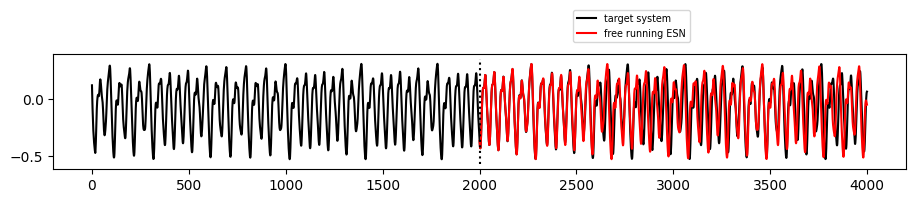

In [ ]:
import numpy as np
from pyESN import ESN
from matplotlib import pyplot as plt
%matplotlib inline

data = np.load('mackey_glass_t17.npy') #  http://minds.jacobs-university.de/mantas/code
esn = ESN(n_inputs = 1,
          n_outputs = 1,
          n_reservoir = 500,
          spectral_radius = 1.5,
          random_state=42)

trainlen = 2000
future = 2000
pred_training = esn.fit(np.ones(trainlen),data[:trainlen])

prediction = esn.predict(np.ones(future))
print("test error: \n"+str(np.sqrt(np.mean((prediction.flatten() - data[trainlen:trainlen+future])**2))))

plt.figure(figsize=(11,1.5))
plt.plot(range(0,trainlen+future),data[0:trainlen+future],'k',label="target system")
plt.plot(range(trainlen,trainlen+future),prediction,'r', label="free running ESN")
lo,hi = plt.ylim()
plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'k:')
plt.legend(loc=(0.61,1.1),fontsize='x-small')

AssertionError: Unknown demapping method

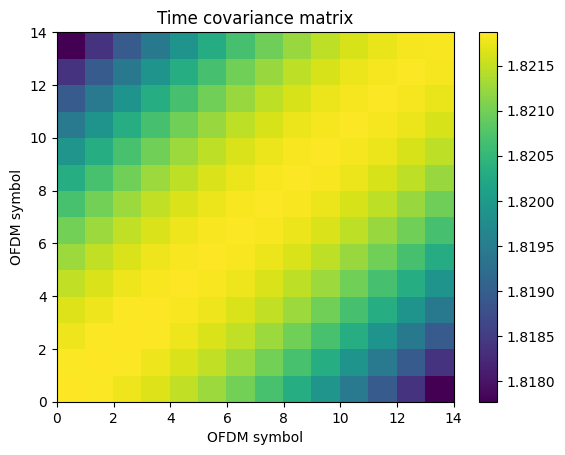

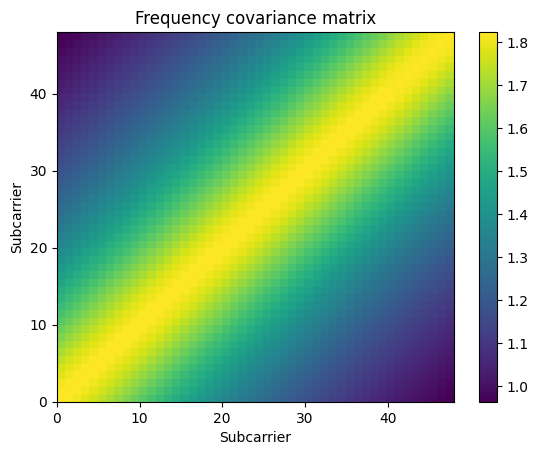

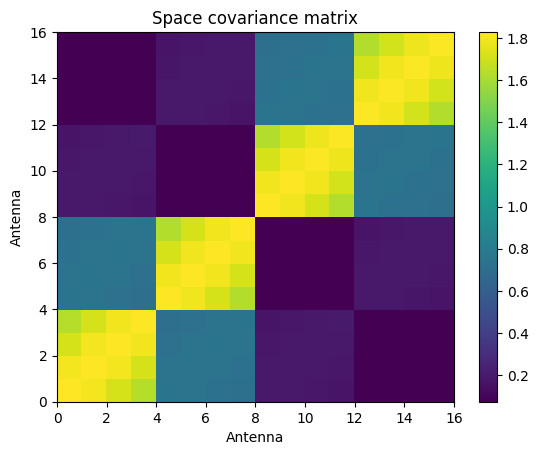

In [9]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0  # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna==0.19")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

sionna.config.seed = 42  # Set seed for reproducible random number generation

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

from tensorflow.keras import Model

from tensorflow.nn import relu

from sionna.mimo import StreamManagement
from sionna.utils import QAMSource, compute_ser, BinarySource, sim_ber, ebnodb2no, QAMSource
from sionna.mapping import Mapper
from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEInterpolator, LinearDetector, KBestDetector, EPDetector, MMSEPICDetector
from sionna.channel import GenerateOFDMChannel, OFDMChannel, gen_single_sector_topology
from sionna.channel.tr38901 import UMi, Antenna, PanelArray
from sionna.fec.ldpc import LDPC5GEncoder
from sionna.fec.ldpc import LDPC5GDecoder

NUM_OFDM_SYMBOLS = 14
FFT_SIZE = 12*4  # 4 PRBs
SUBCARRIER_SPACING = 30e3  # Hz
CARRIER_FREQUENCY = 3.5e9  # Hz
SPEED = 3.  # m/s

# The user terminals (UTs) are equipped with a single antenna
# with vertical polarization.
UT_ANTENNA = Antenna(polarization='single',
                     polarization_type='V',
                     antenna_pattern='omni',  # Omnidirectional antenna pattern
                     carrier_frequency=CARRIER_FREQUENCY)

# The base station is equipped with an antenna
# array of 8 cross-polarized antennas,
# resulting in a total of 16 antenna elements.
NUM_RX_ANT = 16
BS_ARRAY = PanelArray(num_rows_per_panel=4,
                      num_cols_per_panel=2,
                      polarization='dual',
                      polarization_type='cross',
                      antenna_pattern='38.901',  # 3GPP 38.901 antenna pattern
                      carrier_frequency=CARRIER_FREQUENCY)

# 3GPP UMi channel model is considered
CHANNEL_MODEL = UMi(carrier_frequency=CARRIER_FREQUENCY,
                    o2i_model='low',
                    ut_array=UT_ANTENNA,
                    bs_array=BS_ARRAY,
                    direction='uplink',
                    enable_shadow_fading=False,
                    enable_pathloss=False)

rg = ResourceGrid(num_ofdm_symbols=NUM_OFDM_SYMBOLS,
                  fft_size=FFT_SIZE,
                  subcarrier_spacing=SUBCARRIER_SPACING)
channel_sampler = GenerateOFDMChannel(CHANNEL_MODEL, rg)

def sample_channel(batch_size):
    # Sample random topologies
    topology = gen_single_sector_topology(batch_size, 1, 'umi', min_ut_velocity=SPEED, max_ut_velocity=SPEED)
    CHANNEL_MODEL.set_topology(*topology)

    # Sample channel frequency responses
    # [batch size, 1, num_rx_ant, 1, 1, num_ofdm_symbols, fft_size]
    h_freq = channel_sampler(batch_size)
    # [batch size, num_rx_ant, num_ofdm_symbols, fft_size]
    h_freq = h_freq[:,0,:,0,0]

    return h_freq

@tf.function  # Removed jit_compile=True to avoid XLA compilation error
def estimate_covariance_matrices(num_it, batch_size):
    freq_cov_mat = tf.zeros([FFT_SIZE, FFT_SIZE], tf.complex64)
    time_cov_mat = tf.zeros([NUM_OFDM_SYMBOLS, NUM_OFDM_SYMBOLS], tf.complex64)
    space_cov_mat = tf.zeros([NUM_RX_ANT, NUM_RX_ANT], tf.complex64)
    for _ in tf.range(num_it):
        # [batch size, num_rx_ant, num_ofdm_symbols, fft_size]
        h = sample_channel(batch_size)
        h = tf.transpose(h, [0, 2, 3, 1])  # [batch size, num_ofdm_symbols, fft_size, num_rx_ant]

        # Frequency covariance
        h_freq = tf.transpose(h, [0, 3, 1, 2])  # [batch, num_rx_ant, num_ofdm_symbols, fft_size]
        h_freq = tf.reshape(h_freq, [-1, FFT_SIZE])  # [batch*num_rx_ant*num_ofdm_symbols, fft_size]
        freq_cov = tf.matmul(h_freq, h_freq, adjoint_a=True) / tf.cast(tf.shape(h_freq)[0], tf.complex64)
        freq_cov_mat += freq_cov / tf.cast(num_it, tf.complex64)

        # Time covariance
        h_time = tf.transpose(h, [0, 3, 2, 1])  # [batch, num_rx_ant, fft_size, num_ofdm_symbols]
        h_time = tf.reshape(h_time, [-1, NUM_OFDM_SYMBOLS])  # [batch*num_rx_ant*fft_size, num_ofdm_symbols]
        time_cov = tf.matmul(h_time, h_time, adjoint_a=True) / tf.cast(tf.shape(h_time)[0], tf.complex64)
        time_cov_mat += time_cov / tf.cast(num_it, tf.complex64)

        # Space covariance
        h_space = tf.reshape(h, [-1, NUM_RX_ANT])  # [batch*num_ofdm_symbols*fft_size, num_rx_ant]
        space_cov = tf.matmul(h_space, h_space, adjoint_a=True) / tf.cast(tf.shape(h_space)[0], tf.complex64)
        space_cov_mat += space_cov / tf.cast(num_it, tf.complex64)

    return time_cov_mat, freq_cov_mat, space_cov_mat

time_cov_mat, freq_cov_mat, space_cov_mat = estimate_covariance_matrices(100, 1000)
plt.figure()
plt.pcolor(tf.abs(time_cov_mat))
plt.colorbar()
plt.title("Time covariance matrix")
plt.xlabel("OFDM symbol")
plt.ylabel("OFDM symbol")

plt.figure()
plt.pcolor(tf.abs(freq_cov_mat))
plt.colorbar()
plt.title("Frequency covariance matrix")
plt.xlabel("Subcarrier")
plt.ylabel("Subcarrier")

plt.figure()
plt.pcolor(tf.abs(space_cov_mat))
plt.colorbar()
plt.title("Space covariance matrix")
plt.xlabel("Antenna")
plt.ylabel("Antenna")

stream_management = StreamManagement(rx_tx_association=np.array([[1]]), num_streams_per_tx=1)

class MIMODetector(Model):
    def __init__(self, detector, output="hard_bits", **kwargs):
        super().__init__(**kwargs)

        self.stream_management = StreamManagement(rx_tx_association=np.array([[1]]),
                                                  num_streams_per_tx=1)
        self.constellation = sionna.mapping.Constellation("qam", num_bits_per_symbol=4)
        self.mapper = Mapper(constellation=self.constellation)
        self.rg_mapper = ResourceGridMapper(rg)
        self.ls_est = LSChannelEstimator(rg, interpolation_type="nn")
        self.lmmse_est = LSChannelEstimator(rg, interpolation_type="lin_smoothing")
        self.lmmse_int = LMMSEInterpolator(time_cov_mat, freq_cov_mat, space_cov_mat)
        self.detector = detector

        self.binary_source = BinarySource()
        self.awgn = sionna.channel.AWGN()

        if output == "hard_bits":
            self.demapper = sionna.mapping.Demapper("app", constellation=self.constellation)
            self.xor = sionna.utils.XOR()
            self.binary_accuracy = sionna.utils.BinaryAccuracy()

        self.output = output

    def call(self, batch_size, ebno_db):
        no = ebnodb2no(ebno_db, 4, 1.0)

        b = self.binary_source([batch_size, 1, rg.num_data_symbols * self.constellation.num_bits_per_symbol])
        c = self.mapper(b)
        x_rg = self.rg_mapper(c)

        h_freq = sample_channel(batch_size)
        channel_model = OFDMChannel(h_freq, rg, add_awgn=False, normalize_channel=True)

        y = channel_model(x_rg)
        y = self.awgn(y, no)

        h_hat, tau_hat = self.ls_est([y, no])
        h_hat_int = self.lmmse_int([h_hat, tau_hat])

        if self.output == "symbols":
            x_hat = self.detector([y, h_hat_int, no])
            return c, x_hat
        elif self.output == "hard_symbols":
            x_hat = self.detector([y, h_hat_int, no])
            c_hat = sionna.mapping.hard_decisions(x_hat, self.constellation.points)
            return c, c_hat
        elif self.output == "soft_bits":
            llr = self.detector([y, h_hat_int, no])
            return b, llr
        elif self.output == "hard_bits":
            llr = self.detector([y, h_hat_int, no])
            b_hat = tf.cast(llr > 0, tf.float32)
            return b, b_hat
        else:
            raise ValueError("Unknown output type")

def train_detector(detector, num_epochs=10, batch_size=32, lr=1e-3):
    optimizer = tf.keras.optimizers.Adam(lr)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    for e in range(num_epochs):
        for i in range(10):
            ebno_db = tf.random.uniform([batch_size], minval=0.0, maxval=10.0)
            b, llr = detector(batch_size, ebno_db)
            with tf.GradientTape() as tape:
                l = loss(b, llr)
            grads = tape.gradient(l, detector.trainable_weights)
            optimizer.apply_gradients(zip(grads, detector.trainable_weights))
        print(f"Epoch {e}: Loss {l.numpy():.3f}")

# Linear detector
detector = LinearDetector("zf", "symbol", "mimo", rg, stream_management)
linear_detector = MIMODetector(detector)

# K-best detector
detector = KBestDetector("symbol", num_streams=1, k=16, constellation=sionna.mapping.Constellation("qam", 4))
kbest_detector = MIMODetector(detector)

# EP detector
detector = EPDetector("symbol", "qam", 4, hard_out=False)
ep_detector = MIMODetector(detector, output="soft_bits")

# MMSE-PIC detector
detector = MMSEPICDetector("app", "qam", sionna.mapping.Constellation("qam", 4), 4, num_iter=3, hard_out=False)
mmse_pic_detector = MIMODetector(detector, output="soft_bits")

# Run simulations
ebno_dbs = np.arange(0, 21, 2)
ber, bler = sim_ber(linear_detector, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100)
plt.plot(ebno_dbs, ber[0], label="Linear ZF")
ber, bler = sim_ber(kbest_detector, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100)
plt.plot(ebno_dbs, ber[0], label="K-Best")
ber, bler = sim_ber(ep_detector, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100)
plt.plot(ebno_dbs, ber[0], label="EP")
ber, bler = sim_ber(mmse_pic_detector, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100)
plt.plot(ebno_dbs, ber[0], label="MMSE-PIC")
plt.yscale("log")
plt.xlabel("Eb/No [dB]")
plt.ylabel("BER")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0  # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna==0.19")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

sionna.config.seed = 42  # Set seed for reproducible random number generation

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

from tensorflow.keras import Model

from tensorflow.nn import relu

from sionna.mimo import StreamManagement
from sionna.utils import QAMSource, compute_ser, BinarySource, sim_ber, ebnodb2no, QAMSource
from sionna.mapping import Mapper
from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEInterpolator, LinearDetector, KBestDetector, EPDetector, MMSEPICDetector
from sionna.channel import GenerateOFDMChannel, OFDMChannel, gen_single_sector_topology
from sionna.channel.tr38901 import UMi, Antenna, PanelArray
from sionna.fec.ldpc import LDPC5GEncoder
from sionna.fec.ldpc import LDPC5GDecoder

NUM_OFDM_SYMBOLS = 14
FFT_SIZE = 12*4  # 4 PRBs
SUBCARRIER_SPACING = 30e3  # Hz
CARRIER_FREQUENCY = 3.5e9  # Hz
SPEED = 3.  # m/s

# The user terminals (UTs) are equipped with a single antenna
# with vertical polarization.
UT_ANTENNA = Antenna(polarization='single',
                     polarization_type='V',
                     antenna_pattern='omni',  # Omnidirectional antenna pattern
                     carrier_frequency=CARRIER_FREQUENCY)

# The base station is equipped with an antenna
# array of 8 cross-polarized antennas,
# resulting in a total of 16 antenna elements.
NUM_RX_ANT = 2
BS_ARRAY = PanelArray(num_rows_per_panel=4,
                      num_cols_per_panel=2,
                      polarization='dual',
                      polarization_type='cross',
                      antenna_pattern='38.901',  # 3GPP 38.901 antenna pattern
                      carrier_frequency=CARRIER_FREQUENCY)

# 3GPP UMi channel model is considered
CHANNEL_MODEL = UMi(carrier_frequency=CARRIER_FREQUENCY,
                    o2i_model='low',
                    ut_array=UT_ANTENNA,
                    bs_array=BS_ARRAY,
                    direction='uplink',
                    enable_shadow_fading=False,
                    enable_pathloss=False)

rg = ResourceGrid(num_ofdm_symbols=NUM_OFDM_SYMBOLS,
                  fft_size=FFT_SIZE,
                  subcarrier_spacing=SUBCARRIER_SPACING)
channel_sampler = GenerateOFDMChannel(CHANNEL_MODEL, rg)

def sample_channel(batch_size):
    # Sample random topologies
    topology = gen_single_sector_topology(batch_size, 1, 'umi', min_ut_velocity=SPEED, max_ut_velocity=SPEED)
    CHANNEL_MODEL.set_topology(*topology)

    # Sample channel frequency responses
    # [batch size, 1, num_rx_ant, 1, 1, num_ofdm_symbols, fft_size]
    h_freq = channel_sampler(batch_size)
    # [batch size, num_rx_ant, num_ofdm_symbols, fft_size]
    h_freq = h_freq[:,0,:,0,0]

    return h_freq

@tf.function  # Removed jit_compile=True to avoid XLA compilation error
def estimate_covariance_matrices(num_it, batch_size):
    freq_cov_mat = tf.zeros([FFT_SIZE, FFT_SIZE], tf.complex64)
    time_cov_mat = tf.zeros([NUM_OFDM_SYMBOLS, NUM_OFDM_SYMBOLS], tf.complex64)
    space_cov_mat = tf.zeros([NUM_RX_ANT, NUM_RX_ANT], tf.complex64)
    for _ in tf.range(num_it):
        # [batch size, num_rx_ant, num_ofdm_symbols, fft_size]
        h = sample_channel(batch_size)
        h = tf.transpose(h, [0, 2, 3, 1])  # [batch size, num_ofdm_symbols, fft_size, num_rx_ant]

        # Frequency covariance
        h_freq = tf.transpose(h, [0, 3, 1, 2])  # [batch, num_rx_ant, num_ofdm_symbols, fft_size]
        h_freq = tf.reshape(h_freq, [-1, FFT_SIZE])  # [batch*num_rx_ant*num_ofdm_symbols, fft_size]
        freq_cov = tf.matmul(h_freq, h_freq, adjoint_a=True) / tf.cast(tf.shape(h_freq)[0], tf.complex64)
        freq_cov_mat += freq_cov / tf.cast(num_it, tf.complex64)

        # Time covariance
        h_time = tf.transpose(h, [0, 3, 2, 1])  # [batch, num_rx_ant, fft_size, num_ofdm_symbols]
        h_time = tf.reshape(h_time, [-1, NUM_OFDM_SYMBOLS])  # [batch*num_rx_ant*fft_size, num_ofdm_symbols]
        time_cov = tf.matmul(h_time, h_time, adjoint_a=True) / tf.cast(tf.shape(h_time)[0], tf.complex64)
        time_cov_mat += time_cov / tf.cast(num_it, tf.complex64)

        # Space covariance
        h_space = tf.reshape(h, [-1, NUM_RX_ANT])  # [batch*num_ofdm_symbols*fft_size, num_rx_ant]
        space_cov = tf.matmul(h_space, h_space, adjoint_a=True) / tf.cast(tf.shape(h_space)[0], tf.complex64)
        space_cov_mat += space_cov / tf.cast(num_it, tf.complex64)

    return time_cov_mat, freq_cov_mat, space_cov_mat

time_cov_mat, freq_cov_mat, space_cov_mat = estimate_covariance_matrices(100, 1000)
plt.figure()
plt.pcolor(tf.abs(time_cov_mat))
plt.colorbar()
plt.title("Time covariance matrix")
plt.xlabel("OFDM symbol")
plt.ylabel("OFDM symbol")

plt.figure()
plt.pcolor(tf.abs(freq_cov_mat))
plt.colorbar()
plt.title("Frequency covariance matrix")
plt.xlabel("Subcarrier")
plt.ylabel("Subcarrier")

plt.figure()
plt.pcolor(tf.abs(space_cov_mat))
plt.colorbar()
plt.title("Space covariance matrix")
plt.xlabel("Antenna")
plt.ylabel("Antenna")

stream_management = StreamManagement(rx_tx_association=np.array([[1]]), num_streams_per_tx=1)

class MIMODetector(Model):
    def __init__(self, detector, output="hard_bits", **kwargs):
        super().__init__(**kwargs)

        self.stream_management = StreamManagement(rx_tx_association=np.array([[1]]),
                                                  num_streams_per_tx=1)
        self.constellation = sionna.mapping.Constellation("qam", num_bits_per_symbol=4)
        self.mapper = Mapper(constellation=self.constellation)
        self.rg_mapper = ResourceGridMapper(rg)
        self.ls_est = LSChannelEstimator(rg, interpolation_type="nn")
        self.lmmse_est = LSChannelEstimator(rg, interpolation_type="lin_smoothing")
        self.lmmse_int = LMMSEInterpolator(time_cov_mat, freq_cov_mat, space_cov_mat)
        self.detector = detector

        self.binary_source = BinarySource()
        self.awgn = sionna.channel.AWGN()

        if output == "hard_bits":
            self.demapper = sionna.mapping.Demapper("app", constellation=self.constellation)
            self.xor = sionna.utils.XOR()
            self.binary_accuracy = sionna.utils.BinaryAccuracy()

        self.output = output

    def call(self, batch_size, ebno_db):
        no = ebnodb2no(ebno_db, 4, 1.0)

        b = self.binary_source([batch_size, 1, rg.num_data_symbols * self.constellation.num_bits_per_symbol])
        c = self.mapper(b)
        x_rg = self.rg_mapper(c)

        h_freq = sample_channel(batch_size)
        channel_model = OFDMChannel(h_freq, rg, add_awgn=False, normalize_channel=True)

        y = channel_model(x_rg)
        y = self.awgn(y, no)

        h_hat, tau_hat = self.ls_est([y, no])
        h_hat_int = self.lmmse_int([h_hat, tau_hat])

        if self.output == "symbols":
            x_hat = self.detector([y, h_hat_int, no])
            return c, x_hat
        elif self.output == "hard_symbols":
            x_hat = self.detector([y, h_hat_int, no])
            c_hat = sionna.mapping.hard_decisions(x_hat, self.constellation.points)
            return c, c_hat
        elif self.output == "soft_bits":
            llr = self.detector([y, h_hat_int, no])
            return b, llr
        elif self.output == "hard_bits":
            llr = self.detector([y, h_hat_int, no])
            b_hat = tf.cast(llr > 0, tf.float32)
            return b, b_hat
        else:
            raise ValueError("Unknown output type")

def train_detector(detector, num_epochs=10, batch_size=32, lr=1e-3):
    optimizer = tf.keras.optimizers.Adam(lr)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    for e in range(num_epochs):
        for i in range(10):
            ebno_db = tf.random.uniform([batch_size], minval=0.0, maxval=10.0)
            b, llr = detector(batch_size, ebno_db)
            with tf.GradientTape() as tape:
                l = loss(b, llr)
            grads = tape.gradient(l, detector.trainable_weights)
            optimizer.apply_gradients(zip(grads, detector.trainable_weights))
        print(f"Epoch {e}: Loss {l.numpy():.3f}")

# Linear detector
detector = LinearDetector("zf", "bit", "maxlog", rg, stream_management, "qam", 4, hard_out=False)
linear_detector = MIMODetector(detector, output="hard_bits")

# K-best detector
detector = KBestDetector("bit", 1, 16, rg, stream_management, "qam", 4, hard_out=False)
kbest_detector = MIMODetector(detector, output="hard_bits")

# EP detector
detector = EPDetector("bit", "qam", 4, hard_out=False)
ep_detector = MIMODetector(detector, output="hard_bits")

# MMSE-PIC detector
detector = MMSEPICDetector("bit", "maxlog", rg, stream_management, "qam", 4, num_iter=3, hard_out=False)
mmse_pic_detector = MIMODetector(detector, output="hard_bits")

# Run simulations
ebno_dbs = np.arange(0, 21, 2)
ber, bler = sim_ber(linear_detector, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100)
plt.plot(ebno_dbs, ber[0], label="Linear ZF")
ber, bler = sim_ber(kbest_detector, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100)
plt.plot(ebno_dbs, ber[0], label="K-Best")
ber, bler = sim_ber(ep_detector, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100)
plt.plot(ebno_dbs, ber[0], label="EP")
ber, bler = sim_ber(mmse_pic_detector, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100)
plt.plot(ebno_dbs, ber[0], label="MMSE-PIC")
plt.yscale("log")
plt.xlabel("Eb/No [dB]")
plt.ylabel("BER")
plt.legend()
plt.grid(True)
plt.show()

AssertionError: Wrong constellation type.

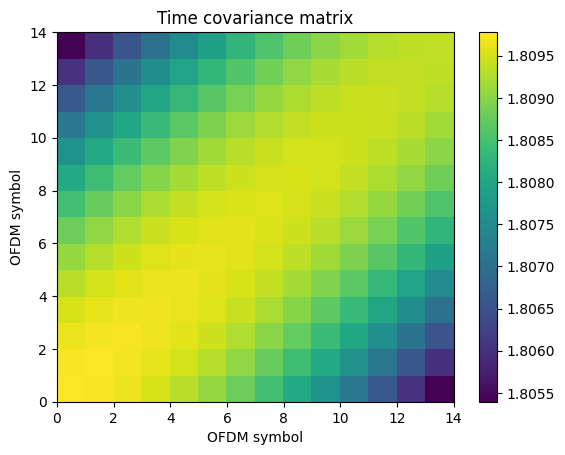

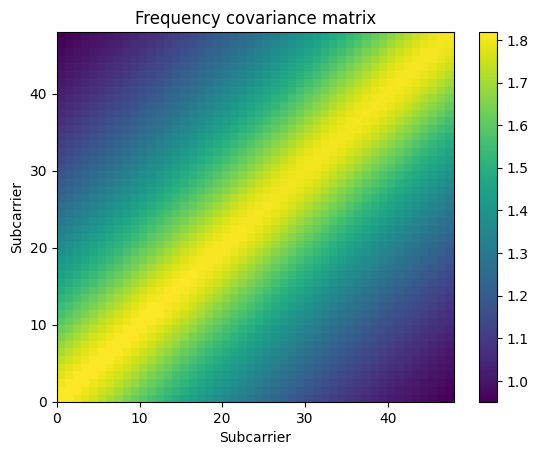

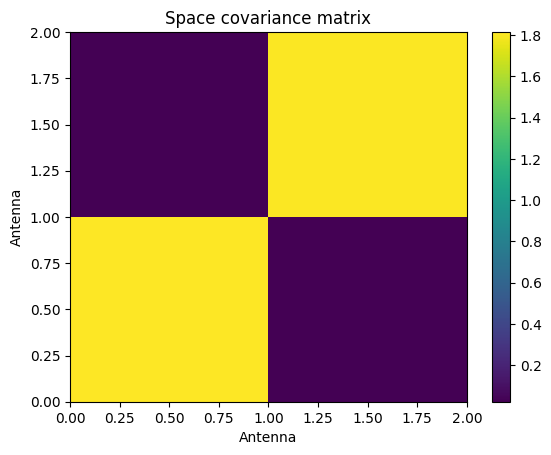

In [6]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = ""  # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna==0.19")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

sionna.config.seed = 42  # Set seed for reproducible random number generation

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

from tensorflow.keras import Model

from tensorflow.nn import relu

from sionna.mimo import StreamManagement
from sionna.utils import QAMSource, compute_ser, BinarySource, sim_ber, ebnodb2no, QAMSource
from sionna.mapping import Mapper
from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEInterpolator, LinearDetector, KBestDetector, EPDetector, MMSEPICDetector
from sionna.ofdm import KroneckerPilotPattern
from sionna.channel import GenerateOFDMChannel, OFDMChannel, gen_single_sector_topology
from sionna.channel.tr38901 import UMi, Antenna, PanelArray
from sionna.fec.ldpc import LDPC5GEncoder
from sionna.fec.ldpc import LDPC5GDecoder

NUM_OFDM_SYMBOLS = 14
FFT_SIZE = 12*4  # 4 PRBs
SUBCARRIER_SPACING = 30e3  # Hz
CARRIER_FREQUENCY = 3.5e9  # Hz
SPEED = 3.  # m/s

NUM_TX_ANT = 2
NUM_RX_ANT = 2
NUM_STREAMS_PER_TX = 2

# The user terminals (UTs) are equipped with a dual-polarized antenna.
UT_ARRAY = PanelArray(num_rows_per_panel=1,
                      num_cols_per_panel=1,
                      polarization='dual',
                      polarization_type='cross',
                      antenna_pattern='omni',
                      carrier_frequency=CARRIER_FREQUENCY)

# The base station is equipped with a dual-polarized antenna array.
BS_ARRAY = PanelArray(num_rows_per_panel=1,
                      num_cols_per_panel=1,
                      polarization='dual',
                      polarization_type='cross',
                      antenna_pattern='38.901',
                      carrier_frequency=CARRIER_FREQUENCY)

# 3GPP UMi channel model is considered
CHANNEL_MODEL = UMi(carrier_frequency=CARRIER_FREQUENCY,
                    o2i_model='low',
                    ut_array=UT_ARRAY,
                    bs_array=BS_ARRAY,
                    direction='uplink',
                    enable_shadow_fading=False,
                    enable_pathloss=False)

rg = ResourceGrid(num_ofdm_symbols=NUM_OFDM_SYMBOLS,
                  fft_size=FFT_SIZE,
                  subcarrier_spacing=SUBCARRIER_SPACING)
rg.pilot_pattern = KroneckerPilotPattern(rg, pilot_ofdm_symbol_indices=[0, 7])

channel_sampler = GenerateOFDMChannel(CHANNEL_MODEL, rg)

def sample_channel(batch_size):
    # Sample random topologies
    topology = gen_single_sector_topology(batch_size, 1, 'umi', min_ut_velocity=SPEED, max_ut_velocity=SPEED)
    CHANNEL_MODEL.set_topology(*topology)

    # Sample channel frequency responses
    # [batch size, 1, num_rx_ant, 1, num_tx_ant, num_ofdm_symbols, fft_size]
    h_freq = channel_sampler(batch_size)
    # [batch size, num_rx_ant, num_tx_ant, num_ofdm_symbols, fft_size]
    h_freq = h_freq[:,0,:,0,:]

    return h_freq

@tf.function  # Removed jit_compile=True to avoid XLA compilation error
def estimate_covariance_matrices(num_it, batch_size):
    freq_cov_mat = tf.zeros([FFT_SIZE, FFT_SIZE], tf.complex64)
    time_cov_mat = tf.zeros([NUM_OFDM_SYMBOLS, NUM_OFDM_SYMBOLS], tf.complex64)
    space_cov_mat = tf.zeros([NUM_RX_ANT, NUM_RX_ANT], tf.complex64)
    for _ in tf.range(num_it):
        # [batch size, num_rx_ant, num_tx_ant, num_ofdm_symbols, fft_size]
        h = sample_channel(batch_size)

        # Frequency covariance
        h_freq = tf.reshape(h, [-1, FFT_SIZE])  # [batch*num_rx_ant*num_tx_ant*num_ofdm_symbols, fft_size]
        freq_cov = tf.matmul(h_freq, h_freq, adjoint_a=True) / tf.cast(tf.shape(h_freq)[0], tf.complex64)
        freq_cov_mat += freq_cov / tf.cast(num_it, tf.complex64)

        # Time covariance
        h_time = tf.transpose(h, [0, 1, 2, 4, 3])  # [batch, num_rx_ant, num_tx_ant, fft_size, num_ofdm_symbols]
        h_time = tf.reshape(h_time, [-1, NUM_OFDM_SYMBOLS])  # [batch*num_rx_ant*num_tx_ant*fft_size, num_ofdm_symbols]
        time_cov = tf.matmul(h_time, h_time, adjoint_a=True) / tf.cast(tf.shape(h_time)[0], tf.complex64)
        time_cov_mat += time_cov / tf.cast(num_it, tf.complex64)

        # Space covariance
        h_space = tf.transpose(h, [0, 2, 3, 4, 1])  # [batch, num_tx_ant, num_ofdm_symbols, fft_size, num_rx_ant]
        h_space = tf.reshape(h_space, [-1, NUM_RX_ANT])  # [batch*num_tx_ant*num_ofdm_symbols*fft_size, num_rx_ant]
        space_cov = tf.matmul(h_space, h_space, adjoint_a=True) / tf.cast(tf.shape(h_space)[0], tf.complex64)
        space_cov_mat += space_cov / tf.cast(num_it, tf.complex64)

    return time_cov_mat, freq_cov_mat, space_cov_mat

time_cov_mat, freq_cov_mat, space_cov_mat = estimate_covariance_matrices(20, 200)
plt.figure()
plt.pcolor(tf.abs(time_cov_mat))
plt.colorbar()
plt.title("Time covariance matrix")
plt.xlabel("OFDM symbol")
plt.ylabel("OFDM symbol")

plt.figure()
plt.pcolor(tf.abs(freq_cov_mat))
plt.colorbar()
plt.title("Frequency covariance matrix")
plt.xlabel("Subcarrier")
plt.ylabel("Subcarrier")

plt.figure()
plt.pcolor(tf.abs(space_cov_mat))
plt.colorbar()
plt.title("Space covariance matrix")
plt.xlabel("Antenna")
plt.ylabel("Antenna")

stream_management = StreamManagement(rx_tx_association=np.array([[1]]), num_streams_per_tx=NUM_STREAMS_PER_TX)

class MIMODetector(Model):
    def __init__(self, detector, output="hard_bits", **kwargs):
        super().__init__(**kwargs)

        self.stream_management = StreamManagement(rx_tx_association=np.array([[1]]),
                                                  num_streams_per_tx=NUM_STREAMS_PER_TX)
        self.constellation = sionna.mapping.Constellation("qam", num_bits_per_symbol=4)
        self.mapper = Mapper(constellation=self.constellation)
        self.rg_mapper = ResourceGridMapper(resource_grid=rg, stream_management=self.stream_management)
        self.ls_est = LSChannelEstimator(rg, interpolation_type="nn")
        self.lmmse_est = LSChannelEstimator(rg, interpolation_type="lin_smoothing")
        self.lmmse_int = LMMSEInterpolator(time_cov_mat, freq_cov_mat, space_cov_mat)
        self.detector = detector

        self.binary_source = BinarySource()
        self.awgn = sionna.channel.AWGN()

        if output == "hard_bits":
            self.demapper = sionna.mapping.Demapper("app", constellation=self.constellation)
            self.xor = sionna.utils.XOR()
            self.binary_accuracy = sionna.utils.BinaryAccuracy()

        self.output = output
        self.num_streams_per_tx = NUM_STREAMS_PER_TX

    def call(self, batch_size, ebno_db):
        no = ebnodb2no(ebno_db, 4, 1.0)

        num_bits = self.num_streams_per_tx * rg.num_data_symbols * self.constellation.num_bits_per_symbol
        b = self.binary_source([batch_size, 1, num_bits])
        c = self.mapper(b)
        c = tf.reshape(c, [batch_size, self.num_streams_per_tx, rg.num_data_symbols])
        c = self.stream_management.map_transmit_streams(c)
        x_rg = self.rg_mapper(c)

        
        h_freq = sample_channel(batch_size)
        channel_model = OFDMChannel(h_freq, rg, add_awgn=False, normalize_channel=True)

        y = channel_model(x_rg)
        y = self.awgn(y, no)

        h_hat, tau_hat = self.ls_est([y, no])
        h_hat_int = self.lmmse_int([h_hat, tau_hat])

        if self.output == "symbols":
            x_hat = self.detector([y, h_hat_int, no])
            return c, x_hat
        elif self.output == "hard_symbols":
            x_hat = self.detector([y, h_hat_int, no])
            c_hat = sionna.mapping.hard_decisions(x_hat, self.constellation.points)
            return c, c_hat
        elif self.output == "soft_bits":
            llr = self.detector([y, h_hat_int, no])
            return b, llr
        elif self.output == "hard_bits":
            llr = self.detector([y, h_hat_int, no])
            b_hat = tf.cast(llr > 0, tf.float32)
            return b, b_hat
        else:
            raise ValueError("Unknown output type")

def train_detector(detector, num_epochs=10, batch_size=32, lr=1e-3):
    optimizer = tf.keras.optimizers.Adam(lr)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    for e in range(num_epochs):
        for i in range(10):
            ebno_db = tf.random.uniform([batch_size], minval=0.0, maxval=10.0)
            b, llr = detector(batch_size, ebno_db)
            with tf.GradientTape() as tape:
                l = loss(b, llr)
            grads = tape.gradient(l, detector.trainable_weights)
            optimizer.apply_gradients(zip(grads, detector.trainable_weights))
        print(f"Epoch {e}: Loss {l.numpy():.3f}")

# Linear detector
detector = LinearDetector("zf", "bit", "maxlog", rg, "qam", num_bits_per_symbol=4, hard_out=False)
linear_detector = MIMODetector(detector, output="hard_bits")

# K-best detector
detector = KBestDetector("bit", NUM_STREAMS_PER_TX, 16, "qam", num_bits_per_symbol=4, hard_out=False)
kbest_detector = MIMODetector(detector, output="hard_bits")

# EP detector
detector = EPDetector("bit", "qam", 4, hard_out=False)
ep_detector = MIMODetector(detector, output="hard_bits")

# MMSE-PIC detector
detector = MMSEPICDetector("bit", "maxlog", rg, "qam", 4, num_iter=3, hard_out=False)
mmse_pic_detector = MIMODetector(detector, output="hard_bits")


# Run simulations
ebno_dbs = np.arange(0, 21, 2)
ber, bler = sim_ber(linear_detector, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100)
plt.plot(ebno_dbs, ber[0], label="Linear ZF")
ber, bler = sim_ber(kbest_detector, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100)
plt.plot(ebno_dbs, ber[0], label="K-Best")
ber, bler = sim_ber(ep_detector, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100)
plt.plot(ebno_dbs, ber[0], label="EP")
ber, bler = sim_ber(mmse_pic_detector, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100)
plt.plot(ebno_dbs, ber[0], label="MMSE-PIC")
plt.yscale("log")
plt.xlabel("Eb/No [dB]")
plt.ylabel("BER")
plt.legend()
plt.grid(True)
plt.show()